In [47]:
import pandas as pd
import os

master_file = 'FullDataCsv/master.csv' 

master = pd.read_csv(master_file)

# Extract NIFTY50 data
symbol = master[master['tradingsymbol'] == 'NIFTY 50'].iloc[0]
symbol_key = symbol['key']

data_filename = f"{symbol_key}.csv"
data_filepath = os.path.join('FullDataCsv', data_filename)

nifty_data = pd.read_csv(data_filepath)
print("Actual data for 'NIFTY 50' (first few rows):")
print(nifty_data.head())


Actual data for 'NIFTY 50' (first few rows):
                   timestamp     open     high      low    close  volume
0  2017-01-02 09:15:00+05:30  8210.10  8211.70  8189.00  8189.55     0.0
1  2017-01-02 09:16:00+05:30  8188.75  8193.95  8188.75  8189.95     0.0
2  2017-01-02 09:17:00+05:30  8190.15  8190.75  8173.70  8173.70     0.0
3  2017-01-02 09:18:00+05:30  8173.35  8177.55  8169.15  8177.55     0.0
4  2017-01-02 09:19:00+05:30  8177.85  8178.15  8173.45  8174.40     0.0


In [48]:
import pandas as pd
import os
import pickle

# Read the master info 
master_file = 'FullDataCsv/master.csv'
info = pd.read_csv(master_file)

# Dictionary for indices
list_indices = {}
for i in range(0, 9):
    
    symbol = info.loc[i, 'tradingsymbol']
    key_val = info.loc[i, 'key']
    symbol_clean = symbol.replace(" ", "")
    filepath = os.path.join('FullDataCsv', f"{key_val}.csv")
    list_indices[symbol_clean] = pd.read_csv(filepath)

# Dictionary for NIFTY50 stocks 
list_nifty50 = {}
for i in range(9, 59):
    symbol = info.loc[i, 'tradingsymbol']
    key_val = info.loc[i, 'key']
    symbol_clean = symbol.replace(" ", "")
    filepath = os.path.join('FullDataCsv', f"{key_val}.csv")
    list_nifty50[symbol_clean] = pd.read_csv(filepath)

# Dictionary for NIFTY MID-CAP 100 stocks
list_nifty100_mc = {}
for i in range(59, 159):
    symbol = info.loc[i, 'tradingsymbol']
    key_val = info.loc[i, 'key']
    symbol_clean = symbol.replace(" ", "")
    filepath = os.path.join('FullDataCsv', f"{key_val}.csv")
    list_nifty100_mc[symbol_clean] = pd.read_csv(filepath)


In [32]:
# Select Nifty50 index
nifty50_data = list_indices['NIFTY50']


nifty50_data['timestamp'] = pd.to_datetime(nifty50_data['timestamp'])
nifty50_data['date'] = nifty50_data['timestamp'].dt.date
nifty50_data = nifty50_data.sort_values(by='timestamp')

# Group daily
nifty50_daily= nifty50_data.groupby('date').agg(
    open=('open', 'first'),   # First minute's open price
    high=('high', 'max'),     # Highest price of the day
    low=('low', 'min'),       # Lowest price of the day
    close=('close', 'last'),  # Last minute's close price
    volume=('volume', 'sum')  # Sum of volumes for the day
).reset_index()

# Compute the total volume as the sum of the total intraday volume of the nifty50 stocks
daily_volumes = []

for symbol, df in list_nifty50.items():
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['date'] = df['timestamp'].dt.date

    daily_volume = df.groupby('date').agg(volume=('volume', 'sum')).reset_index()
    daily_volume['symbol'] = symbol  
    daily_volumes.append(daily_volume)

all_daily_volume = pd.concat(daily_volumes, ignore_index=True)

# Now, aggregate total volume for each day across all stocks by summing individual stock volumes
total_daily_volume = all_daily_volume.groupby('date').agg(
    combined_volume=('volume', 'sum')
).reset_index()



# Merge combined volume into the nifty50_daily dataframe
nifty50_daily = nifty50_daily.merge(total_daily_volume, how='left', on='date')
nifty50_daily.drop(columns='volume', inplace=True)
nifty50_daily.rename(columns={'combined_volume': 'volume'}, inplace=True)
print(nifty50_daily.head())


         date     open     high      low    close       volume
0  2017-01-02  8210.10  8211.70  8134.30  8179.20  117899647.0
1  2017-01-03  8195.25  8219.00  8148.65  8189.05  135579792.0
2  2017-01-04  8200.80  8218.45  8180.95  8196.35  141064841.0
3  2017-01-05  8226.65  8282.55  8223.90  8270.50  166577105.0
4  2017-01-06  8283.00  8306.50  8233.45  8248.20  150211913.0


Filtered data points: 90810
Log returns head:
timestamp
2019-01-02 09:16:00+05:30    0.000963
2019-01-02 09:17:00+05:30    0.000382
2019-01-02 09:18:00+05:30    0.000460
2019-01-02 09:19:00+05:30    0.000525
2019-01-02 09:20:00+05:30    0.000419
Name: close, dtype: float64


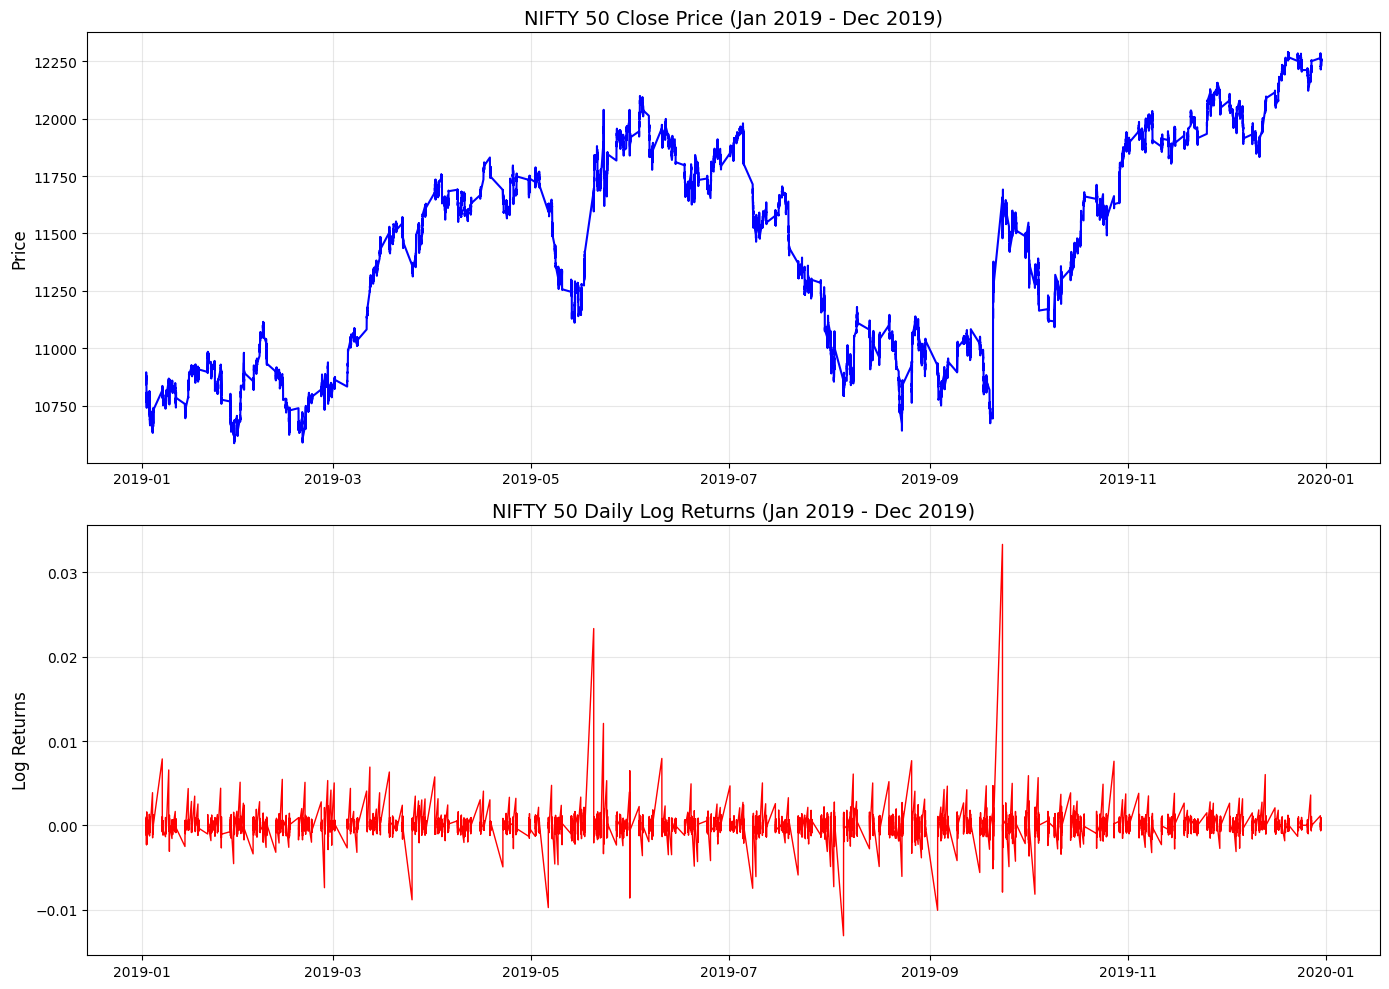

Original returns count: 90786
Returns after removing 17:00 hour: 90726


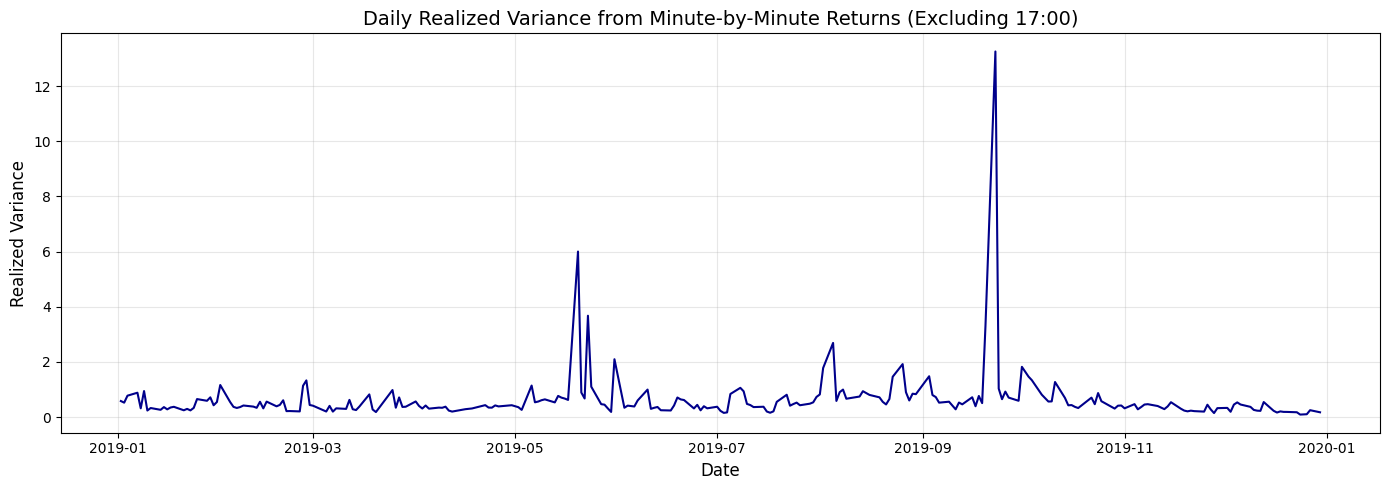

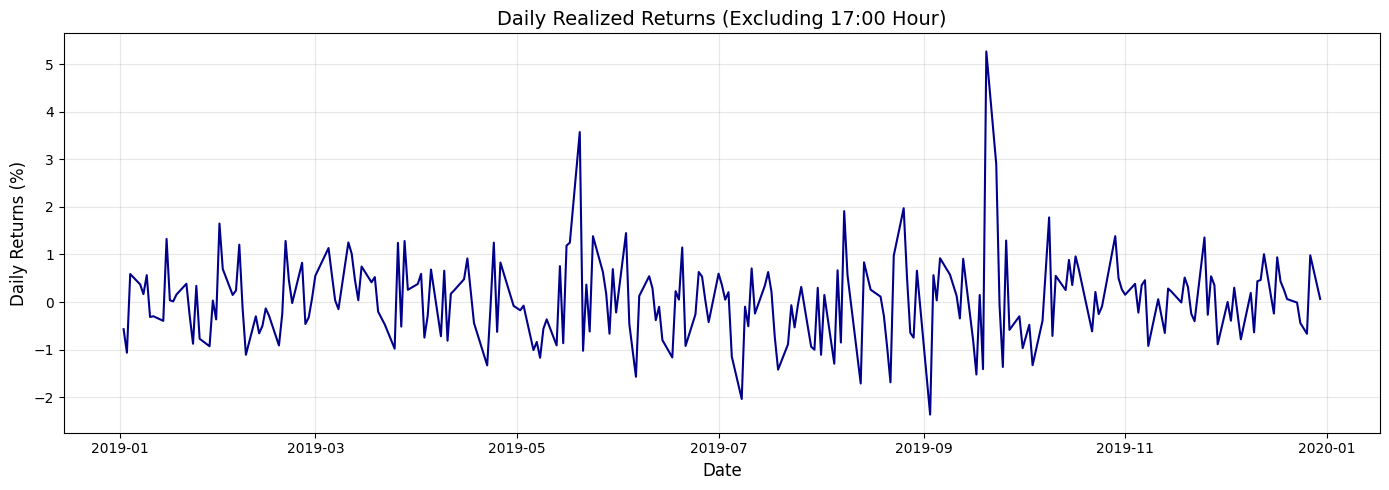

timestamp
2019-01-02 09:16:00+05:30    0.000963
2019-01-02 09:17:00+05:30    0.000382
2019-01-02 09:18:00+05:30    0.000460
2019-01-02 09:19:00+05:30    0.000525
2019-01-02 09:20:00+05:30    0.000419
                               ...   
2019-01-02 10:51:00+05:30   -0.000179
2019-01-02 10:52:00+05:30    0.000041
2019-01-02 10:53:00+05:30    0.000009
2019-01-02 10:54:00+05:30   -0.000069
2019-01-02 10:55:00+05:30   -0.000161
Name: close, Length: 100, dtype: float64


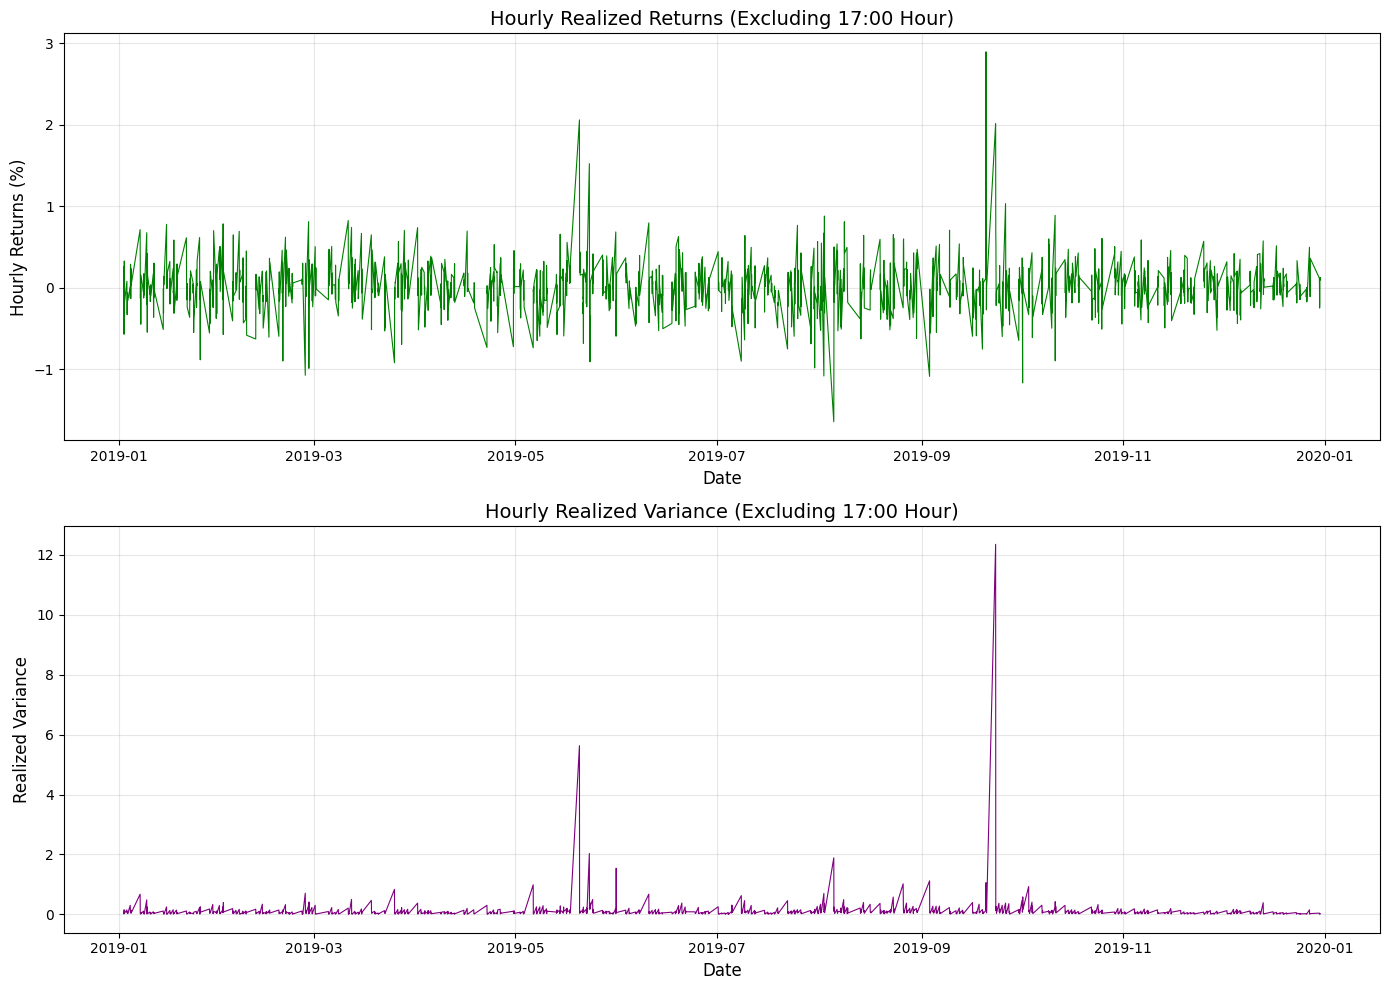


ADF Test (No constant, no trend) for Daily Returns (Excluding 17:00 Hour):
ADF Statistic: -14.772031843687842
p-value: 2.2985911548264896e-26
Critical Values: {'1%': np.float64(-2.5750796256951496), '5%': np.float64(-1.9421702285426112), '10%': np.float64(-1.615762841121653)}

ADF Test (With constant/drift, no trend) for Daily Returns (Excluding 17:00 Hour):
ADF Statistic: -14.790373292254447
p-value: 2.1758894432055884e-27
Critical Values: {'1%': np.float64(-3.4577787098622674), '5%': np.float64(-2.873608704758507), '10%': np.float64(-2.573201765981991)}

ADF Test (With constant and trend) for Daily Returns (Excluding 17:00 Hour):
ADF Statistic: -14.760203422492044
p-value: 2.9553060149044424e-22
Critical Values: {'1%': np.float64(-3.9968337688702165), '5%': np.float64(-3.4288662447936313), '10%': np.float64(-3.1378478075975025)}

Stationarity Test for Hourly Returns (Excluding 17:00 Hour):
ADF Statistic: -21.09919033602449
p-value: 0.0
Critical Value (1%): -3.434223006770802
Critica

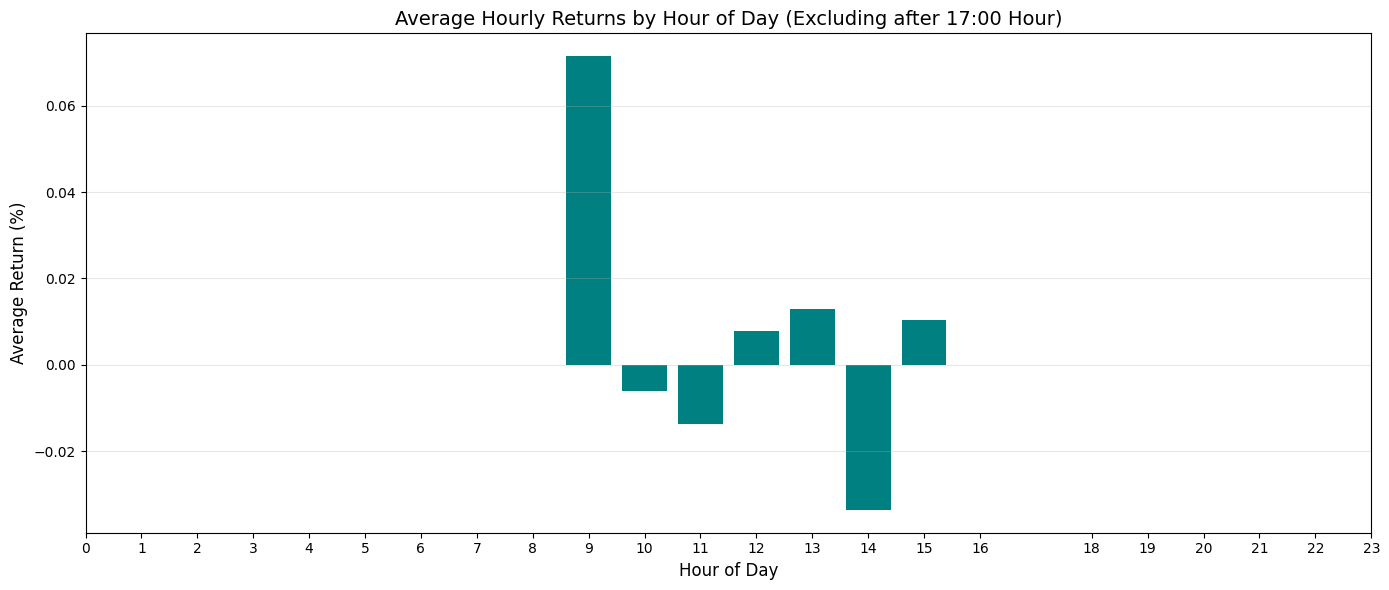

In [130]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import statsmodels.tsa.stattools as ts

# Set 'timestamp' as the index (make sure your DataFrame is sorted by timestamp)
#nifty50_data.set_index('timestamp', inplace=True)


# Filter data for specific date range
data_start_date = pd.Timestamp("2019-01-02", tz="Asia/Kolkata")
data_end_date = pd.Timestamp("2019-12-31", tz="Asia/Kolkata")



filtered_stock_data = nifty50_data.loc[data_start_date:data_end_date]['close']
print(f"Filtered data points: {filtered_stock_data.size}")

# Calculate log returns
returns = np.log(filtered_stock_data/filtered_stock_data.shift(1))
returns = returns.dropna()
print("Log returns head:")
print(returns.head())

# Create price and returns plots
plt.figure(figsize=(14, 10))

# Plot price Time Series
plt.subplot(2, 1, 1)
plt.plot(filtered_stock_data.index, filtered_stock_data.values, 'b-', linewidth=1.5)
plt.title('NIFTY 50 Close Price (Jan 2019 - Dec 2019)', fontsize=14)
plt.ylabel('Price', fontsize=12)
plt.grid(True, alpha=0.3)

# Returns Time Series
plt.subplot(2, 1, 2)
plt.plot(returns.index, returns.values, 'r-', linewidth=1)
plt.title('NIFTY 50 Daily Log Returns (Jan 2019 - Dec 2019)', fontsize=14)
plt.ylabel('Log Returns', fontsize=12)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Make sure the index is datetime
returns.index = pd.to_datetime(returns.index)

# Filter out 17:00 hour returns
filtered_returns = returns[returns.index.hour != 17]


filtered_returns= returns[
    (returns.index.hour >= 9) & (returns.index.hour <= 15)
]


print(f"Original returns count: {len(returns)}")
print(f"Returns after removing 17:00 hour: {len(filtered_returns)}")

# Calculate squared returns for variance calculation
squared_returns = (filtered_returns*100) ** 2

# Calculate daily realized variance
daily_realized_variance = squared_returns.groupby(filtered_returns.index.floor('D')).sum()
daily_realized_variance = pd.Series(daily_realized_variance, name='Realized Variance')

plt.figure(figsize=(14, 5))
plt.plot(daily_realized_variance.index, daily_realized_variance.values, color='darkblue')
plt.title('Daily Realized Variance from Minute-by-Minute Returns (Excluding 17:00)', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Realized Variance', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Calculate daily returns (excluding 17:00 hour data)
daily_returns = filtered_returns.groupby(filtered_returns.index.floor('D')).sum() * 100
daily_returns = pd.Series(daily_returns, name='Daily Log Return')

plt.figure(figsize=(14, 5))
plt.plot(daily_returns.index, daily_returns.values, color='darkblue')
plt.title('Daily Realized Returns (Excluding 17:00 Hour)', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Daily Returns (%)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Add hourly aggregation (excluding 17:00 hour)
print(filtered_returns.head(100))

hourly_returns = filtered_returns.groupby(filtered_returns.index.floor('h')).sum() * 100
hourly_returns = pd.Series(hourly_returns, name='Hourly Log Return')

# Calculate hourly realized variance
hourly_realized_variance = squared_returns.groupby(filtered_returns.index.floor('h')).sum()
hourly_realized_variance = pd.Series(hourly_realized_variance, name='Hourly Realized Variance')

# Plot hourly returns
plt.figure(figsize=(14, 10))

# Plot 1: Hourly Returns
plt.subplot(2, 1, 1)
plt.plot(hourly_returns.index, hourly_returns.values, color='green', linewidth=0.8)
plt.title('Hourly Realized Returns (Excluding 17:00 Hour)', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Hourly Returns (%)', fontsize=12)
plt.grid(True, alpha=0.3)

# Plot 2: Hourly Realized Variance
plt.subplot(2, 1, 2)
plt.plot(hourly_realized_variance.index, hourly_realized_variance.values, color='purple', linewidth=0.8)
plt.title('Hourly Realized Variance (Excluding 17:00 Hour)', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Realized Variance', fontsize=12)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


# We now perform ADF tests under three model assumptions:

# 1. No constant, no trend
print("\nADF Test (No constant, no trend) for Daily Returns (Excluding 17:00 Hour):")
adf_none = ts.adfuller(daily_returns, regression='n', autolag='BIC', maxlag=10)
print("ADF Statistic:", adf_none[0])
print("p-value:", adf_none[1])
print("Critical Values:", adf_none[4])

# 2. A constant (drift) only 
print("\nADF Test (With constant/drift, no trend) for Daily Returns (Excluding 17:00 Hour):")
adf_drift = ts.adfuller(daily_returns, regression='c', autolag='BIC', maxlag=10)
print("ADF Statistic:", adf_drift[0])
print("p-value:", adf_drift[1])
print("Critical Values:", adf_drift[4])

# 3. Both constant and trend 
print("\nADF Test (With constant and trend) for Daily Returns (Excluding 17:00 Hour):")
adf_trend = ts.adfuller(daily_returns, regression='ct', autolag='AIC', maxlag=10)
print("ADF Statistic:", adf_trend[0])
print("p-value:", adf_trend[1])
print("Critical Values:", adf_trend[4])
# Stationary under all three assumptions




# Stationarity test for hourly returns
print("\nStationarity Test for Hourly Returns (Excluding 17:00 Hour):")
result_hourly = adfuller(hourly_returns.dropna())
print("ADF Statistic:", result_hourly[0])
print("p-value:", result_hourly[1])
for key, value in result_hourly[4].items():
    print(f'Critical Value ({key}): {value}')

if result_hourly[1] < 0.05:
    print("The hourly returns series is stationary (reject H0): proceed with GARCH")
else:
    print("The hourly returns series is non-stationary (fail to reject H0)")
print(daily_returns.mean())

# Visualize hourly patterns - average returns by hour of day
hourly_returns.index = pd.to_datetime(hourly_returns.index)
hourly_returns_by_hour = hourly_returns.groupby(hourly_returns.index.hour).mean()

plt.figure(figsize=(14, 6))
plt.bar(hourly_returns_by_hour.index, hourly_returns_by_hour.values, color='teal')
plt.title('Average Hourly Returns by Hour of Day (Excluding after 17:00 Hour)', fontsize=14)
plt.xlabel('Hour of Day', fontsize=12)
plt.ylabel('Average Return (%)', fontsize=12)
plt.grid(True, alpha=0.3, axis='y')
plt.xticks([hour for hour in range(0, 24) if hour != 17])  # Exclude hour 17 from x-ticks
plt.tight_layout()
plt.show()


In [122]:
# Get the hourly floored datetime index
hourly_index = filtered_returns.index.floor('h').unique()

# Extract just the hour with timezone from the datetime
hours_only = pd.to_datetime(hourly_index).strftime('%H:%M:%S%z')

# If you want it as a list
hours_list = list(hours_only.unique())
print(hours_list)

# Filter rows where hour is 18 or 19
evening_returns = filtered_returns[(filtered_returns.index.hour == 18) | (filtered_returns.index.hour == 19)]

# Get the indices of those rows
evening_indices = evening_returns.index

print(evening_indices.size)
print(evening_indices)





['09:00:00+0530', '10:00:00+0530', '11:00:00+0530', '12:00:00+0530', '13:00:00+0530', '14:00:00+0530', '15:00:00+0530']
0
DatetimeIndex([], dtype='datetime64[ns, UTC+05:30]', name='timestamp', freq=None)


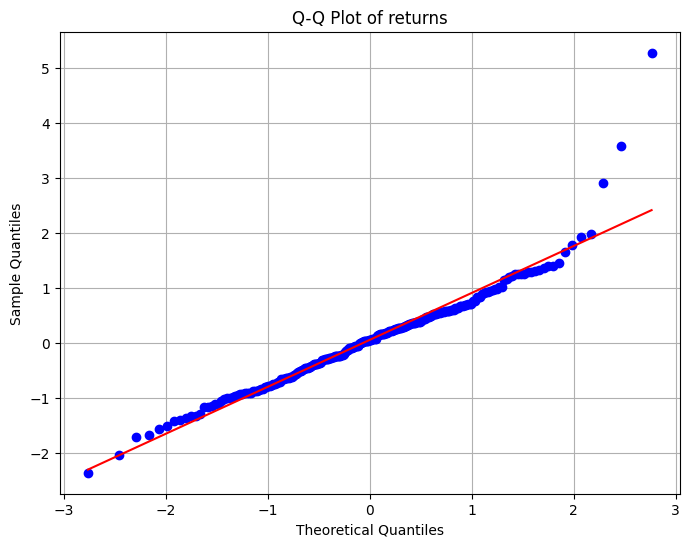

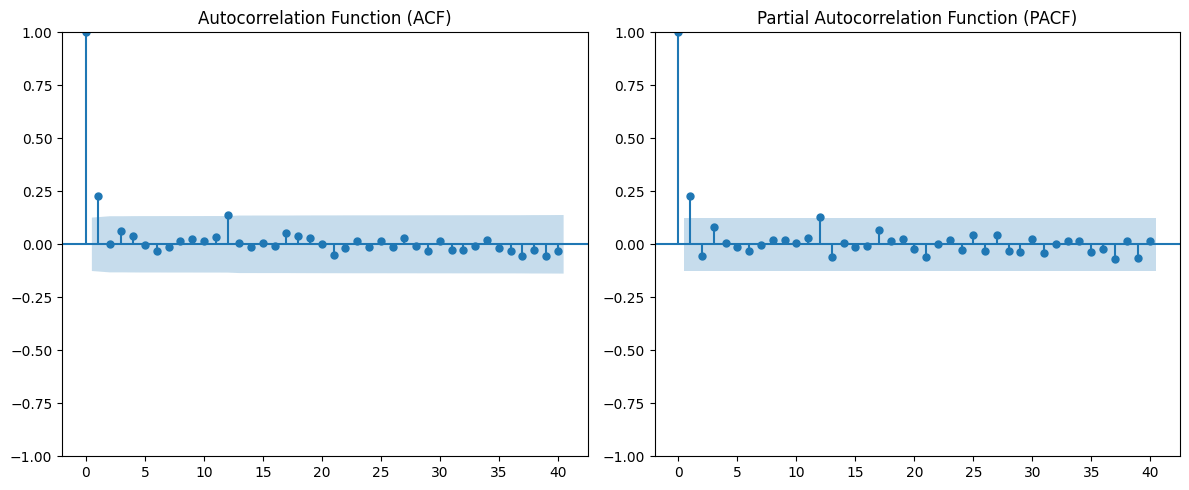

In [131]:
import numpy as np
import scipy.stats as stats

fig, ax = plt.subplots(figsize=(8, 6))
stats.probplot(daily_returns, dist="norm", plot=ax)  # Compare to normal distribution

ax.set_title("Q-Q Plot of returns")
ax.set_xlabel("Theoretical Quantiles")
ax.set_ylabel("Sample Quantiles")
ax.grid(True)

plt.show()

import statsmodels.api as sm
# Compute ACF and PACF
#acf_values = sm.tsa.acf(daily_returns, nlags=40)
#pacf_values = sm.tsa.pacf(daily_returns, nlags=40)


# Plot ACF and PACF
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# ACF Plot
sm.graphics.tsa.plot_acf(daily_returns**2, lags=40, ax=axes[0])
axes[0].set_title("Autocorrelation Function (ACF)")

# PACF Plot
sm.graphics.tsa.plot_pacf(daily_returns**2, lags=40, ax=axes[1])
axes[1].set_title("Partial Autocorrelation Function (PACF)")

plt.tight_layout()
plt.show()


def engle_arch_test(residuals, lags=1):
    """
    Perform Engle's Lagrange Multiplier (LM) test for autoregressive conditional heteroskedasticity (ARCH).
    
    Parameters:
    -----------
    residuals : array-like
        The residuals of a time series model to test for ARCH effects.
    lags : int, optional (default=1)
        Number of lags to include in the test.
        
    Returns:
    --------
    lm_stat : float
        The LM test statistic.
    p_value : float
        The p-value for the test.
    f_stat : float
        The F-statistic version of the test.
    f_p_value : float
        The p-value for the F-statistic.
    """
    # Convert input to numpy array
    resid = np.asarray(residuals)
    nobs = len(resid)
    
    # Calculate squared residuals
    resid_sq = resid**2
    
    # Create lagged squared residuals for regression
    X = np.zeros((nobs - lags, lags + 1))
    X[:, 0] = 1.0  # Constant term
    
    # Fill in lagged squared residuals
    for i in range(1, lags + 1):
        X[:, i] = resid_sq[lags-i:-i]
    
    # Perform regression on squared residuals
    y = resid_sq[lags:]
    results = sm.OLS(y, X).fit()
    
    # Calculate R-squared
    r_squared = results.rsquared
    
    # LM test statistic: nobs * R^2
    lm_stat = nobs * r_squared
    
    # LM test follows a chi-squared distribution with degrees of freedom equal to lags
    p_value = stats.chi2.sf(lm_stat, lags)
    
    # F-statistic version of the test
    f_stat = results.fvalue
    f_p_value = results.f_pvalue
    
    return lm_stat, p_value, f_stat, f_p_value




Iteration 1/242
Skipping iteration 0: not enough training data (0 obs)
Iteration 2/242
Skipping iteration 1: not enough training data (1 obs)
Iteration 3/242
Skipping iteration 2: not enough training data (2 obs)
Iteration 4/242
Skipping iteration 3: not enough training data (3 obs)
Iteration 5/242
Skipping iteration 4: not enough training data (4 obs)
Iteration 6/242
Skipping iteration 5: not enough training data (5 obs)
Iteration 7/242
Skipping iteration 6: not enough training data (6 obs)
Iteration 8/242
Iteration 9/242
Iteration 10/242
Iteration 11/242
Iteration 12/242
Iteration 13/242
Iteration 14/242
Iteration 15/242
Iteration 16/242
Iteration 17/242
Iteration 18/242
Iteration 19/242
Iteration 20/242
Iteration 21/242
Iteration 22/242
Iteration 23/242
Iteration 24/242
Iteration 25/242
Iteration 26/242
Iteration 27/242
Iteration 28/242
Iteration 29/242
Iteration 30/242
Iteration 31/242
Iteration 32/242
Iteration 33/242
Iteration 34/242
Iteration 35/242
Iteration 36/242
Iteration 37

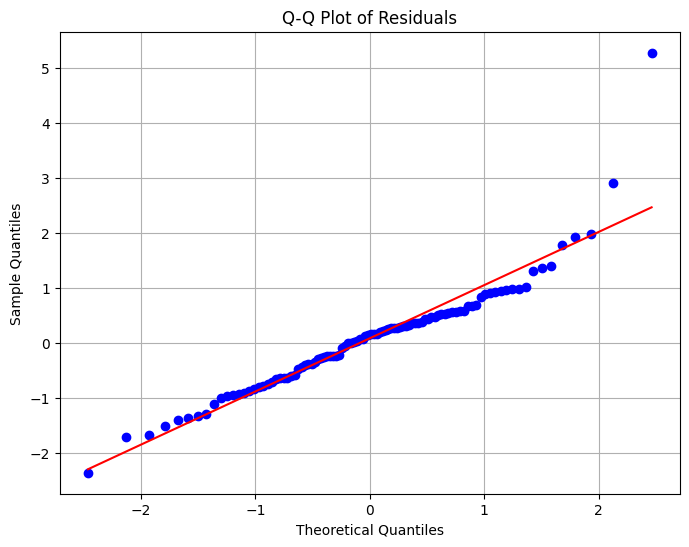

In [132]:
from arch import arch_model
import statsmodels.api as sm
from statsmodels.stats.diagnostic import acorr_ljungbox

rolling_preds = []
rolling_preds_return = []
daily_returns = daily_returns


# Loop through test set to perform rolling one-step-ahead forecast
for i in range(daily_returns.shape[0]):
    print(f"Iteration {i+1}/{daily_returns.shape[0]}")
    train = daily_returns[-(daily_returns.shape[0] - i)-100:-(daily_returns.shape[0] - i)]
    # Skip iteration if training set too short
    if len(train) < 7:
        print(f"Skipping iteration {i}: not enough training data ({len(train)} obs)")
        rolling_preds.append(np.nan)
     
        continue
    

    # Fit GARCH(1,1) model
    
   
    model = arch_model(train, p=1, q=1, mean="Zero", vol="Garch", dist="gaussian", rescale=True)
    

    model_fit = model.fit(disp='off')
    residuals = model_fit.resid
    # One-step ahead forecast of variance
    pred = model_fit.forecast(horizon=1, reindex=True)
    
    # Extract and store forecasted volatility (std deviation)
    forecasted_vol = np.sqrt(pred.variance.values[-1, 0])
    
    rolling_preds.append(forecasted_vol)
    rolling_preds_return.append(pred.simulations.values)


# Align predictions with test data index
rolling_preds = pd.Series(rolling_preds, index=daily_returns.index)
fig, ax = plt.subplots(figsize=(8, 6))
stats.probplot(residuals, dist="norm", plot=ax)  # Compare to normal distribution

ax.set_title("Q-Q Plot of Residuals")
ax.set_xlabel("Theoretical Quantiles")
ax.set_ylabel("Sample Quantiles")
ax.grid(True)

plt.show()



In [133]:
import statsmodels.api as sm

# Create a DataFrame with forecasted variance and realized variance
df_mz = pd.DataFrame({'Realized_Var': daily_realized_variance.dropna(), 'Forecasted_Var': rolling_preds**2}).dropna()
print(df_mz.head())  # See if any rows exist
print(df_mz.shape)   # Ensure it's not empty
# Add a constant for the intercept
X = sm.add_constant(df_mz['Forecasted_Var'])
y = df_mz['Realized_Var']

# Make sure X has at least one row of data
if X.shape[0] == 0 or y.shape[0] == 0:
    print("Error: X or y is empty")
else:
    # Fit the MZ regression model
    model_mz = sm.OLS(y, X).fit()
    # Print summary statistics
    print(model_mz.summary())
print(rolling_preds_return)

                           Realized_Var  Forecasted_Var
timestamp                                              
2019-01-11 00:00:00+05:30      0.326890        0.171832
2019-01-14 00:00:00+05:30      0.261803        0.234352
2019-01-15 00:00:00+05:30      0.360433        0.241491
2019-01-16 00:00:00+05:30      0.278702        0.440400
2019-01-17 00:00:00+05:30      0.345887        0.381588
(235, 2)
                            OLS Regression Results                            
Dep. Variable:           Realized_Var   R-squared:                       0.629
Model:                            OLS   Adj. R-squared:                  0.628
Method:                 Least Squares   F-statistic:                     395.7
Date:                Thu, 10 Apr 2025   Prob (F-statistic):           3.94e-52
Time:                        15:23:33   Log-Likelihood:                -217.61
No. Observations:                 235   AIC:                             439.2
Df Residuals:                     233   BIC:  

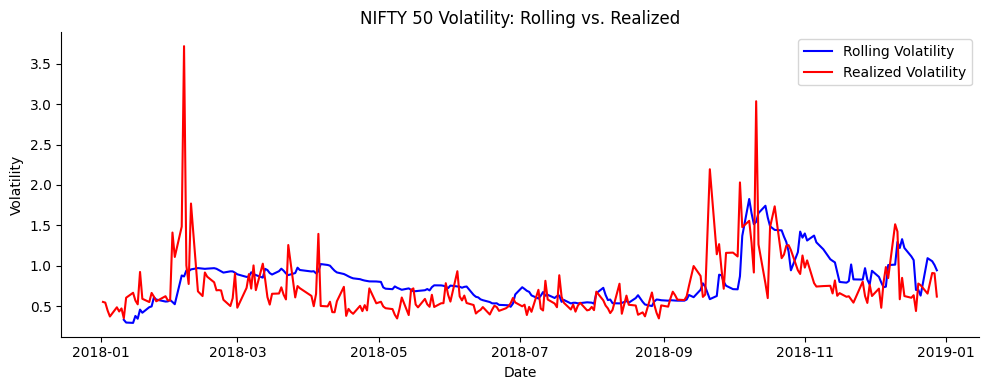

In [120]:
import matplotlib.pyplot as plt
import numpy as np

# --- Figure 1: Volatility ---
fig, ax1 = plt.subplots(figsize=(10, 4))

# Remove top and right spines
ax1.spines[['top', 'right']].set_visible(False)

# Plot Rolling Volatility Prediction
ax1.plot(rolling_preds, color='blue', label='Rolling Volatility')

# Plot Realized Volatility (square root)
ax1.plot(np.sqrt(daily_realized_variance), color='red', label='Realized Volatility')

# Labels and title
ax1.set_title('NIFTY 50 Volatility: Rolling vs. Realized')
ax1.set_xlabel('Date')
ax1.set_ylabel('Volatility')
ax1.legend()

plt.tight_layout()
plt.show()


